# Trabajo opcional de bases de datos, Delta Lake + Apache Spark

Autor: José Antonio

# 1º) Descarga de los datos en local

En GitHub hay dos “formas” principales de acceder a un archivo del repo por URL:

blob = página web (HTML) para humanos

Si tú haces requests.get() a esa URL, descargas el HTML de la página, no el binario del Parquet.

raw = el contenido crudo del archivo (binario/texto)

“Raw” significa el archivo tal cual, sin el HTML. Es la url que necesitamos para descargar los ficheros parquet desde Github

Como spark no nos permite leer un fichero por https directamente, tenemos que descargarlo en local y luego leerlo con spark.

In [1]:
import requests, os, shutil

# Asegurarse de descargar el raw no el blob
url_users = "https://github.com/dsevilla/bd2-data/raw/refs/heads/main/es.stackoverflow/parquet/Users.parquet"
local_path_users = "/content/Users.parquet"
url_tags = "https://github.com/dsevilla/bd2-data/raw/refs/heads/main/es.stackoverflow/parquet/Tags.parquet"
local_path_tags = "/content/Tags.parquet"
url_posts = ['https://github.com/dsevilla/bd2-data/raw/refs/heads/main/es.stackoverflow/parquet/Posts1.parquet',
    'https://github.com/dsevilla/bd2-data/raw/refs/heads/main/es.stackoverflow/parquet/Posts2.parquet',
    'https://github.com/dsevilla/bd2-data/raw/refs/heads/main/es.stackoverflow/parquet/Posts3.parquet']
local_path_posts = "/content/Posts_local"

def download_single_parquet(url, local_path):
  with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(local_path, "wb") as f:
          for chunk in r.iter_content(chunk_size=1024*1024):
              f.write(chunk)

# Luego spark lee la carpeta con todas las partes y saca el dataframe completo
def download_multiple_parquet(urls, local_path):
  dest_dir = local_path
  os.makedirs(dest_dir, exist_ok=True)

  for url in urls:
      filename = url.split("/")[-1]
      path = os.path.join(dest_dir, filename)

      with requests.get(url, stream=True) as r:
          r.raise_for_status()
          with open(path, "wb") as f:
              for chunk in r.iter_content(chunk_size=1024*1024):
                  if chunk:
                      f.write(chunk)

download_single_parquet(url_tags, local_path_tags)
download_single_parquet(url_users, local_path_users)
download_multiple_parquet(url_posts, local_path_posts)

# 2º) Cargamos los parquets originales a delta tables

Librerías necesarias para correr pyspark y delta lake

In [2]:
!pip -q install pyspark==3.5.3 delta-spark==3.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 12.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 3.5.3 which is incompatible.


Sesión de spark

In [3]:
import pyspark
from delta import configure_spark_with_delta_pip
import time


builder = (
    pyspark.sql.SparkSession.builder
    .appName("delta-colab")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

Acceso a la spark ui

In [4]:
spark.range(1).count()

from google.colab import output

ui_url = spark.sparkContext.uiWebUrl  # ej: 'http://...:4040'
print("Spark UI:", ui_url)

# extraer puerto (4040/4041/...)
port = int(ui_url.rsplit(":", 1)[-1])

# abre la UI (Jobs) en una ventana/pestaña embebida de Colab
output.serve_kernel_port_as_window(port, path="/jobs/")

Spark UI: http://9ce9360152ed:4040
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

Cargamos a tablas delta

In [5]:
# Leemos fichero local
df_users = spark.read.parquet(local_path_users)
# Lo convertimos a tabla delta
df_users.write.format("delta").mode("overwrite").save("/content/Users")
os.remove(local_path_users)

In [6]:
df_posts = spark.read.parquet(local_path_posts)
df_posts.write.format("delta").mode("overwrite").save("/content/Posts")
shutil.rmtree(local_path_posts)

Cargamos los datos desde delta lake usando pyspark

In [7]:
df_users = spark.read.format("delta").load("/content/Users")
df_posts = spark.read.format("delta").load("/content/Posts")

https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=2810&context=sis_research

In [9]:
df_posts.createOrReplaceTempView("Posts")
df_users.createOrReplaceTempView("Users")

# 3º) Ejecución y optimización de consultas RQ1-RQ4

## RQ1

In [11]:
spark.catalog.clearCache()
spark.sql("CLEAR CACHE")

DataFrame[]

In [12]:
%%time
spark.sql("""SELECT t.NQuest, COUNT(*) AS NUsers
FROM (SELECT COUNT(*) AS NQuest
      FROM Posts
      WHERE PostTypeId = 1 AND OwnerUserId IS NOT NULL
      GROUP BY OwnerUserId) AS t
WHERE NQuest <= 34
GROUP BY t.NQuest
ORDER BY t.NQuest""").count() # spark.sql de por si no ejecuta nada hasta que llega a una acción, por eso hacemos el count

CPU times: user 2.55 ms, sys: 169 µs, total: 2.72 ms
Wall time: 4.52 s


34

In [32]:
df = spark.sql("""SELECT t.NQuest, COUNT(*) AS NUsers
FROM (SELECT COUNT(*) AS NQuest
      FROM Posts
      WHERE PostTypeId = 1 AND OwnerUserId IS NOT NULL
      GROUP BY OwnerUserId) AS t
WHERE NQuest <= 34
AND NQuest > 0
GROUP BY t.NQuest
ORDER BY t.NQuest""")

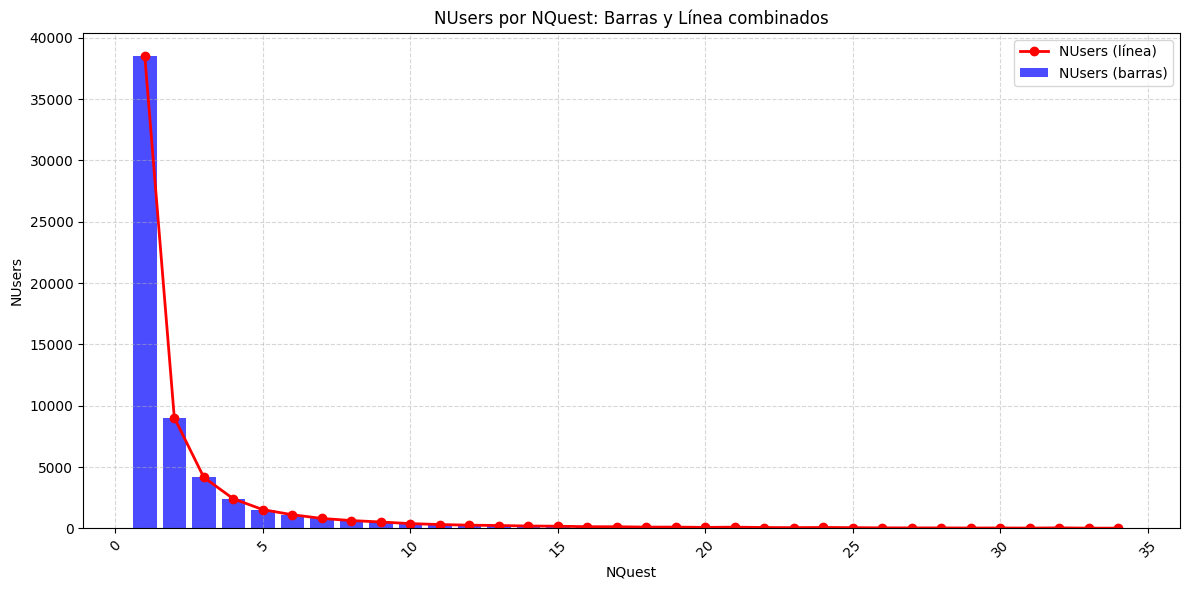

In [33]:
import matplotlib.pyplot as plt

pdf = df.select("NQuest", "NUsers").toPandas()
x = pdf["NQuest"].tolist()
y = pdf["NUsers"].tolist()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras
ax1.bar(x, y, color='blue', label='NUsers (barras)', alpha=0.7)

# Gráfico de líneas sobre el mismo eje
ax1.plot(x, y, color='red', marker='o', linestyle='-', linewidth=2, label='NUsers (línea)')

# Etiquetas y título
ax1.set_xlabel('NQuest')
ax1.set_ylabel('NUsers')
ax1.set_title('NUsers por NQuest: Barras y Línea combinados')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# Ajustar para que las etiquetas del eje X no se solapen (opcional)
plt.xticks(rotation=45)

# Ajustar layout
plt.tight_layout()

# Mostrar
plt.show()

## RQ2

In [ ]:
spark.catalog.clearCache()
spark.sql("CLEAR CACHE")

DataFrame[]

In [ ]:
%%time
spark.sql("""
SELECT t.NAnswers, COUNT(*) AS NUsers
FROM (SELECT COUNT(p.Id) AS NAnswers
      FROM Posts p RIGHT JOIN Users u ON (p.OwnerUserId = u.Id) AND p.PostTypeId = 2
      GROUP BY u.Id
      ORDER BY 1 DESC) AS t
WHERE NAnswers <= 130
GROUP BY t.NAnswers
ORDER BY t.NAnswers
""").count()

CPU times: user 3.79 ms, sys: 407 µs, total: 4.2 ms
Wall time: 10.6 s


130

In [23]:
df = spark.sql("""
SELECT t.NAnswers, COUNT(*) AS NUsers
FROM (SELECT COUNT(p.Id) AS NAnswers
      FROM Posts p RIGHT JOIN Users u ON (p.OwnerUserId = u.Id) AND p.PostTypeId = 2
      GROUP BY u.Id
      ORDER BY 1 DESC) AS t
WHERE NAnswers <= 130
GROUP BY t.NAnswers
ORDER BY t.NAnswers
""")

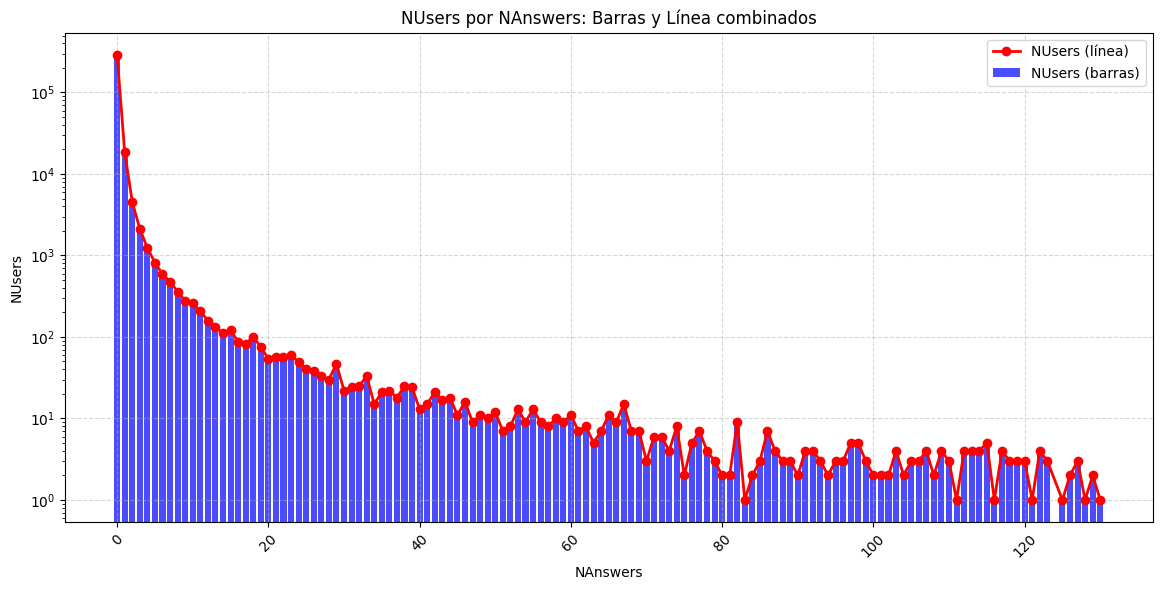

In [24]:
pdf = df.select("NAnswers", "NUsers").toPandas()
x = pdf["NAnswers"].tolist()
y = pdf["NUsers"].tolist()
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras
ax1.bar(x, y, color='blue', label='NUsers (barras)', alpha=0.7)

# Gráfico de líneas sobre el mismo eje
ax1.plot(x, y, color='red', marker='o', linestyle='-', linewidth=2, label='NUsers (línea)')

# Etiquetas y título
ax1.set_xlabel('NAnswers')
ax1.set_ylabel('NUsers')
ax1.set_title('NUsers por NAnswers: Barras y Línea combinados')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# Ajustar para que las etiquetas del eje X no se solapen (opcional)
plt.xticks(rotation=45)

# Ajustar layout
plt.tight_layout()

ax1.set_yscale('log')

# Mostrar
plt.show()

## RQ3

In [10]:
spark.catalog.clearCache()
spark.sql("CLEAR CACHE")

DataFrame[]

In [11]:
%%time
spark.sql("""
SELECT U.Id,
       t2.Total,
       t.NAnswers,
       COALESCE((t.NAnswers/t2.Total), 0) AS PercAnswers
FROM
Users U
LEFT JOIN
(SELECT OwnerUserId, COUNT(*) AS NAnswers
      FROM Posts
      WHERE PostTypeId = 2 AND OwnerUserId IS NOT NULL
      GROUP BY OwnerUserId) t
ON U.Id = t.OwnerUserId
LEFT JOIN
(SELECT OwnerUserId, COUNT(*) AS Total
      FROM Posts
      WHERE OwnerUserId IS NOT NULL AND (PostTypeId = 1 OR PostTypeId = 2)
      GROUP BY OwnerUserId) t2
ON U.Id = t2.OwnerUserid
""").count()

CPU times: user 4.39 ms, sys: 722 µs, total: 5.11 ms
Wall time: 12.7 s


319535

In [35]:
df = spark.sql("""
SELECT U.Id,
       t2.Total,
       t.NAnswers,
       COALESCE((t.NAnswers/t2.Total), 0) AS PercAnswers
FROM
Users U
LEFT JOIN
(SELECT OwnerUserId, COUNT(*) AS NAnswers
      FROM Posts
      WHERE PostTypeId = 2 AND OwnerUserId IS NOT NULL
      GROUP BY OwnerUserId) t
ON U.Id = t.OwnerUserId
LEFT JOIN
(SELECT OwnerUserId, COUNT(*) AS Total
      FROM Posts
      WHERE OwnerUserId IS NOT NULL AND (PostTypeId = 1 OR PostTypeId = 2)
      GROUP BY OwnerUserId) t2
ON U.Id = t2.OwnerUserid
""")

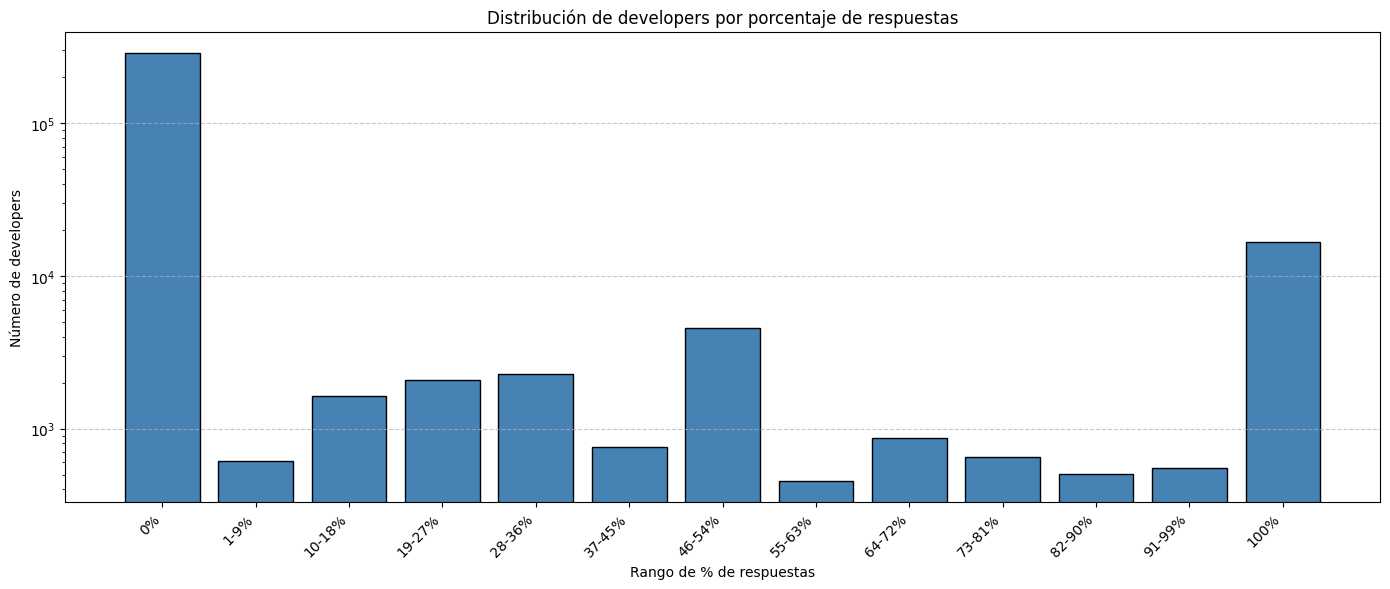

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



df_plot = df.select("PercAnswers").toPandas()

def assign_bin(val):
    if val == 0.0:
        return '0%'
    elif val == 1.0:
        return '100%'
    else:
        # Convertir a porcentaje entero
        pct = val * 100
        # Asignar a rango: 1-9 → "1-9%", 10-18 → "10-18%", etc.
        lower = int(pct // 9) * 9 + 1
        upper = lower + 8
        if upper > 99:
            upper = 99
        return f"{int(lower)}-{int(upper)}%"

df_plot['Bin'] = df_plot['PercAnswers'].apply(assign_bin)

# Ahora contar por bin
counts = df_plot['Bin'].value_counts().sort_index(key=lambda x: [
    -1 if s == '0%' else (1000 if s == '100%' else int(s.split('-')[0]))
    for s in x
])

# Pero el sort_index con key no funciona directamente así en pandas antiguo

# Alternativa: crear un orden explícito
bin_order = ['0%']
for start in range(1, 100, 9):
    end = min(start + 8, 99)
    bin_order.append(f"{start}-{end}%")
bin_order.append('100%')

# Reordenar counts
counts = counts.reindex(bin_order).fillna(0).astype(int)

# Ahora graficar
plt.figure(figsize=(14, 6))
plt.bar(counts.index, counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Rango de % de respuestas')
plt.ylabel('Número de developers')
plt.title('Distribución de developers por porcentaje de respuestas')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.tight_layout()
plt.show()

## RQ4

In [ ]:
spark.catalog.clearCache()
spark.sql("CLEAR CACHE")

DataFrame[]

In [ ]:
%%time
spark.sql("""
SELECT DISTINCT
  LEAST(q1.OwnerUserId, q2.OwnerUserId) AS UserA,
  GREATEST(q1.OwnerUserId, q2.OwnerUserId) AS UserB
FROM Posts q1
JOIN Posts a1
  ON a1.ParentId = q1.Id
  AND a1.PostTypeId = 2
  AND q1.PostTypeId = 1
  AND q1.OwnerUserId <> a1.OwnerUserId
JOIN Posts q2
  ON q2.OwnerUserId = a1.OwnerUserId
JOIN Posts a2
  ON a2.ParentId = q2.Id
  AND a2.PostTypeId = 2
  AND a2.OwnerUserId = q1.OwnerUserId
WHERE q2.PostTypeId = 1;
""").count()

CPU times: user 4.87 ms, sys: 2.4 ms, total: 7.26 ms
Wall time: 17.3 s


216

In [37]:
spark.sql("""
SELECT DISTINCT
  LEAST(q1.OwnerUserId, q2.OwnerUserId) AS UserA,
  GREATEST(q1.OwnerUserId, q2.OwnerUserId) AS UserB
FROM Posts q1
JOIN Posts a1
  ON a1.ParentId = q1.Id
  AND a1.PostTypeId = 2
  AND q1.PostTypeId = 1
  AND q1.OwnerUserId <> a1.OwnerUserId
JOIN Posts q2
  ON q2.OwnerUserId = a1.OwnerUserId
JOIN Posts a2
  ON a2.ParentId = q2.Id
  AND a2.PostTypeId = 2
  AND a2.OwnerUserId = q1.OwnerUserId
WHERE q2.PostTypeId = 1;
""").show()

+------+------+
| UserA| UserB|
+------+------+
| 10775| 38468|
| 10576| 29967|
|  3275| 35873|
|  3440|  6491|
| 16597| 29967|
|    83| 29967|
| 91499|180509|
| 24225| 34527|
| 18376| 26302|
|    65|  1184|
| 33256| 77052|
|191045|201156|
|   250|  2163|
|  4229| 29967|
| 28050| 30751|
|  9874| 19919|
| 85496|248814|
|119615|131662|
| 74698| 76420|
| 16349| 29967|
+------+------+
only showing top 20 rows



## Optimización

Para elegir por que columnas de Posts vamos a hacer ZORDER BY vamos a repasar las consultas y ver cuales son las que más se usan en filtros. En RQ1 y RQ3 filtramos por PostTypeId y OwnerUserId, por lo que son los candidatos perfectos por los que hacer ZORDER BY

Para la tabla Users no tiene sentido hacer OPTIMIZE porque se carga como un solo fichero parquet

In [12]:
spark.sql("""
    OPTIMIZE delta.`/content/Posts`
    ZORDER BY (PostTypeId, OwnerUserId)
""")

DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,clusteringStats:struct<inputZCubeFiles:struct<numFiles:bigint,size:bigint>,inputOtherFiles:struct<numFiles:bigint,size:bigint>,inputNumZCubes:bigint,mergedFiles:struct<numFiles:bigint,size:bigint>,numOutputZCubes:bigint>,numBins:bigint,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,

In [13]:
spark.catalog.clearCache()
spark.sql("CLEAR CACHE")

DataFrame[]